In [1]:
import os,sys,time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import copy
import pdb
import time

from torch.utils.data import Dataset, TensorDataset, DataLoader
import torch.optim.lr_scheduler as lr_scheduler

from datetime import datetime

_dtype_ = torch.float32
_device_ = torch.device("mps")

seq_len = 1
seq_len_ma = 10
seq_len_forward = 1

metrics = {}

class PP_MLP(nn.Module): # Price Pridiction

    def __init__(self, seq_len_f):

        super(PP_MLP, self).__init__() 
        self.layer1 = nn.Linear(14, 20)  
        self.layer2 = nn.Linear(20, 20)
        self.layer3 = nn.Linear(20, 20)
        self.output = nn.Linear(20, seq_len_f)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        
        x = self.relu(self.layer1(x)) 
        x = self.relu(self.layer2(x)) 
        x = self.relu(self.layer3(x)) 
        return self.output(x) 
    
class PP_LSTM(nn.Module):
    def __init__(self, seq_len_f):

        super(PP_LSTM, self).__init__()
        self.hidden_dim = 20
        self.lstm = nn.LSTM(14, self.hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.dense_1 = nn.Linear(self.hidden_dim, 20)
        self.dense_2 = nn.Linear(20, 20)
        self.dense_3 = nn.Linear(20, seq_len_f)
        self.relu = nn.ReLU()

    def forward(self, x):

        lstm_out, _ = self.lstm(x)
        
        x = lstm_out[:, -1, :]
        x = self.dropout(x) 
        x = self.relu(self.dense_1(x))
        x = self.relu(self.dense_2(x))
        x = self.dense_3(x)
        
        return x
        
class H5Dataset(Dataset):
    def __init__(self, file_path, norm_flag):
        self.file_path = file_path
        self.dataset = {}

        with h5py.File(self.file_path, 'r') as file:
            self.dataset['inputs'] = file['inputs'][:]
            self.dataset['outputs'] = file['outputs'][:]
            

        if norm_flag == 'n':
            self.normalization()
        if norm_flag == 'd':
            pass
        
    
    def __len__(self):
        return len(self.dataset['inputs'])

    def __getitem__(self, idx):
        input_data = torch.tensor(self.dataset['inputs'][idx], dtype=torch.float32)
        output_data = torch.tensor(self.dataset['outputs'][idx], dtype=torch.float32)
        return input_data, output_data
    
    def normalization(self):
        inputs = self.dataset['inputs']
        outputs = self.dataset['outputs']
        min_vals_i = inputs.min(axis=0)  
        max_vals_i = inputs.max(axis=0)
        if outputs.ndim != 1:
            min_vals_o = np.min(outputs)  
            max_vals_o = np.max(outputs)   
        else:
            min_vals_o = outputs.min(axis=0)  
            max_vals_o = outputs.max(axis=0)         

        ranges_i = max_vals_i - min_vals_i
        ranges_i[ranges_i == 0] = 1

        if (max_vals_o - min_vals_o)!= 0:
            ranges_o = max_vals_o - min_vals_o
        else:
            ranges_o = 1

        self.dataset['inputs'] = (inputs - min_vals_i) / ranges_i
        self.dataset['outputs'] = ((outputs - min_vals_o) / ranges_o).squeeze()

    def add_indices(self):
        inputs = self.dataset['inputs']
        indices = np.arange(inputs.shape[0]).reshape(-1, 1)
        self.dataset['inputs'] = np.hstack((indices, inputs))

def set_learning_rate(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def denormalize_i(dataset, model, input):
    outputs = dataset.dataset['outputs']
    min_vals_o = outputs.min(axis=0)  
    max_vals_o = outputs.max(axis=0)         

    range_o = max_vals_o - min_vals_o

    return (model(input).cpu()*range_o)+min_vals_o

def denormalize_o(dataset, output):
    outputs = dataset.dataset['outputs']
    min_vals_o = outputs.min(axis=0)  
    max_vals_o = outputs.max(axis=0)         

    range_o = max_vals_o - min_vals_o

    return (output*range_o)+min_vals_o


def seq_gen(dataset, inputs, seq_len, device):

    inputs_o = torch.zeros(inputs.shape[0], seq_len, inputs.shape[1]-1)

    for i in range(inputs.shape[0]):

        idx_i = int(inputs[i][0].item())
        start_idx = max(0, idx_i - seq_len + 1)
        end_idx = idx_i + 1
        segment = dataset.dataset['inputs'][start_idx:end_idx, 1:]

        first_col = segment[:, 0]
        diff = np.diff(first_col)
        last_increasing_idx = np.where(diff <= 0)[0]
        if len(last_increasing_idx) > 0:
            cut_point = last_increasing_idx[-1] + 1
        else:
            cut_point = 0

        segment[:cut_point, :] = 0

        segment_tensor = torch.from_numpy(segment)

        fill_start = seq_len - (end_idx - start_idx)

        target_size = seq_len - fill_start
        
        if segment_tensor.shape[0] < target_size:
            padding_size = target_size - segment_tensor.shape[0]
            padding = torch.zeros(padding_size, segment_tensor.shape[1])
            segment_tensor = torch.cat([padding, segment_tensor], dim=0)
        
        
        
        inputs_o[i, fill_start:seq_len, :] = segment_tensor

    return inputs_o.to(device)

def SMA(array, window_length):

    sma = np.zeros(len(array))  

    for i in range(1, len(array)):
        if i < window_length:
            
            sma[i] = np.mean(array[:i])
        else:
            
            sma[i] = np.mean(array[i-window_length:i])
            
    return sma

def EMA(array, window_length):

    ema = np.zeros(len(array))  
    alpha = 2 / (window_length + 1)  

    ema[0] = 0 

    for i in range(1, len(array)):
        if i < window_length:

            temp_alpha = 2 / (i + 1)
            ema[i] = temp_alpha * array[i] + (1 - temp_alpha) * ema[i - 1]
        else:

            ema[i] = alpha * array[i] + (1 - alpha) * ema[i - 1]

    return ema

def moving_average(dataset, method, window_length):

    # method: 'SMA' for Simple Moving Average or 'EMA' for Exponential Moving Average
    outputs = dataset.dataset['outputs']
    time_series = dataset.dataset['inputs'][:, 1]
    segments = np.where(np.diff(time_series) < 0)[0] + 1

    start_index = 0
    results = []

    for end_index in segments:

        current_segment = outputs[start_index:end_index]

        if method == 'SMA':
            ma_values = SMA(current_segment, window_length)
        elif method == 'EMA':
            ma_values = EMA(current_segment, window_length)
        else:
            raise ValueError("Unsupported method. Use 'SMA' or 'EMA'.")

        results.append(ma_values)
        start_index = end_index

    if start_index < len(outputs):
        current_segment = outputs[start_index:]
        if method == 'SMA':
            ma_values = SMA(current_segment, window_length)
        elif method == 'EMA':
            ma_values = EMA(current_segment, window_length)
        results.append(ma_values)

    final_result = np.concatenate(results)
    return final_result




In [1]:
np.lib.stride_tricks.sliding_window_view([0,1,2,3,4,5,6,7,8,9,10], window_shape=3)

NameError: name 'np' is not defined

In [90]:
# LSTM Plot
len_lst = [1,3,5,10,15,20]

for seq_len in len_lst:
    for seq_len_forward in len_lst:
        print(f'Start r{seq_len}_f{seq_len_forward}.')
# seq_len = 1
# seq_len_ma = 10
# seq_len_forward = 20

        dataset_test = H5Dataset(f'../data/lob_data/lob_data_test_f{seq_len_forward}.h5','n')
        dataset_test_dn = H5Dataset(f'../data/lob_data/lob_data_test_f{seq_len_forward}.h5','d')

        dataset_test.add_indices()

        loader_test = DataLoader(dataset_test, batch_size = 4096, shuffle = False)

        model_save_path_LSTM = f'PPLSTM_model_r{seq_len}_f{seq_len_forward}.pt'
        optimizer_save_path_LSTM = f'PPLSTM_optimizer_r{seq_len}_f{seq_len_forward}.pt'

        PPLSTM_model = PP_LSTM(seq_len_forward).to(_device_)
        PPLSTM_model.load_state_dict(torch.load(model_save_path_LSTM))
        PPLSTM_model.eval()

        outputs_NN = []

        for batch_idx, (inputs, labels) in enumerate(loader_test):

            # if seq_len_forward == 1:
            #     inputs, labels = seq_gen(dataset_test, inputs, seq_len, _device_), labels.to(_device_).unsqueeze(1)
            # else:
            #     inputs, labels = seq_gen(dataset_test, inputs, seq_len, _device_), labels.to(_device_)

            with torch.no_grad():
                output_NN = denormalize_i(dataset_test_dn, PPLSTM_model, seq_gen(dataset_test, inputs, seq_len, _device_)).cpu().detach().numpy().squeeze()

            outputs_NN.extend(output_NN)


        # outputs_original = dataset_test_dn.dataset['outputs'].squeeze()
        # outputs_NN = denormalize(dataset_test_dn, PPLSTM_model, seq_gen(dataset_test, inputs, seq_len, _device_)).cpu().detach().numpy().squeeze()
        outputs_original = dataset_test_dn.dataset['outputs']


        metrics[f'LSTM_{seq_len}_{seq_len_forward}'] = {
            'MSE': np.mean((outputs_original - outputs_NN) ** 2),
            'RMSE': np.sqrt(np.mean((outputs_original - outputs_NN) ** 2)),
            'MAE': np.mean(np.abs(outputs_original - outputs_NN)),
            'MAPE': np.mean(np.abs((1 - outputs_NN/outputs_original)))*100,
            'SMAPE': 100 * np.mean(2 * np.abs(outputs_NN - outputs_original) / (np.abs(outputs_NN) + np.abs(outputs_original))),
            'R-squared': 1 - (np.sum((outputs_original - outputs_NN) ** 2) / np.sum((outputs_original - np.mean(outputs_original)) ** 2)),
        }


Start r1_f1.


/var/folders/b6/kmqmc4952k7__8jzcqjy4jn00000gn/T/ipykernel_68022/1136354414.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  PPLSTM_model.load_state_dict(torch.load(mode

Start r1_f3.
Start r1_f5.
Start r1_f10.
Start r1_f20.
Start r3_f1.
Start r3_f3.
Start r3_f5.
Start r3_f10.
Start r3_f20.
Start r5_f1.
Start r5_f3.
Start r5_f5.
Start r5_f10.
Start r5_f20.
Start r10_f1.
Start r10_f3.
Start r10_f5.
Start r10_f10.
Start r10_f20.
Start r20_f1.
Start r20_f3.
Start r20_f5.
Start r20_f10.
Start r20_f20.


In [87]:
seq_len = 3
seq_len_forward = 20

dataset_test = H5Dataset(f'../data/lob_data/lob_data_test_f{seq_len_forward}.h5','n')
dataset_test_dn = H5Dataset(f'../data/lob_data/lob_data_test_f{seq_len_forward}.h5','d')

dataset_test.add_indices()

loader_test = DataLoader(dataset_test, batch_size = 4096, shuffle = False)

model_save_path_LSTM = f'PPLSTM_model_r{seq_len}_f{seq_len_forward}.pt'
optimizer_save_path_LSTM = f'PPLSTM_optimizer_r{seq_len}_f{seq_len_forward}.pt'

PPLSTM_model = PP_LSTM(seq_len_forward).to(_device_)
PPLSTM_model.load_state_dict(torch.load(model_save_path_LSTM))
PPLSTM_model.eval()

outputs_NN = []

for batch_idx, (inputs, labels) in enumerate(loader_test):

    with torch.no_grad():
        output_NN = denormalize(dataset_test_dn, PPLSTM_model, seq_gen(dataset_test, inputs, seq_len, _device_)).cpu().detach().numpy().squeeze()

    outputs_NN.extend(output_NN)

outputs_original = dataset_test_dn.dataset['outputs']

metrics[f'LSTM_{seq_len}_{seq_len_forward}'] = {
    'MSE': np.mean((outputs_original - outputs_NN) ** 2),
    'RMSE': np.sqrt(np.mean((outputs_original - outputs_NN) ** 2)),
    'MAE': np.mean(np.abs(outputs_original - outputs_NN)),
    'MAPE': np.mean(np.abs((1 - outputs_NN/outputs_original)))*100,
    'SMAPE': 100 * np.mean(2 * np.abs(outputs_NN - outputs_original) / (np.abs(outputs_NN) + np.abs(outputs_original))),
    'R-squared': 1 - (np.sum((outputs_original - outputs_NN) ** 2) / np.sum((outputs_original - np.mean(outputs_original)) ** 2)),
}

/var/folders/b6/kmqmc4952k7__8jzcqjy4jn00000gn/T/ipykernel_68022/3363109748.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  PPLSTM_model.load_state_dict(torch.load(mode

In [92]:
import json

def convert_numpy(obj):
    if isinstance(obj, dict):
        return {k: convert_numpy(v) for k, v in obj.items()}
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
                          np.int16, np.int32, np.int64, np.uint8,
                          np.uint16, np.uint32, np.uint64)):
        return int(obj)
    elif isinstance(obj, (np.float_, np.float16, np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, (np.bool_)):
        return bool(obj)
    return obj

# Convert the metric dictionary
metrics_serializable = convert_numpy(metrics)

with open('metrics.json', 'w') as file:
    json.dump(metrics_serializable, file, indent=4)

In [57]:
for i, x in enumerate(values):
    print(i,x)

0 1
1 3
2 5
3 10
4 20


In [66]:
X

array([[ 1,  3,  5, 10, 20],
       [ 1,  3,  5, 10, 20],
       [ 1,  3,  5, 10, 20],
       [ 1,  3,  5, 10, 20],
       [ 1,  3,  5, 10, 20]])

MSE [[175.57167053 202.35765076 213.53181458 241.53642273 266.22149658]
 [230.10055542 220.0606842  232.43707275 252.82913208 414.08499146]
 [280.58087158 252.90325928 373.21035767 324.42730713 408.45831299]
 [292.30007935 214.38626099 310.55996704 377.86465454 346.26806641]
 [212.3581543  279.09912109 332.86941528 306.54537964 369.00967407]]
RMSE [[13.25034618 14.22524738 14.61272812 15.54144192 16.31629562]
 [15.16906548 14.83444214 15.2458868  15.90060139 20.34907913]
 [16.75054932 15.90293217 19.31865311 18.01186562 20.21035194]
 [17.0967865  14.64193535 17.62271118 19.43874168 18.60828018]
 [14.57251358 16.70626068 18.24470901 17.50843811 19.20962524]]
MAE [[10.11895657 10.98548126 11.30045891 12.06665134 12.73526192]
 [11.79108143 11.43312359 11.83644485 12.32101631 16.34873581]
 [12.87655067 12.28961277 15.12259388 14.31007481 16.16479683]
 [13.59481049 11.33950329 13.78127861 15.6726675  14.67786121]
 [11.29605865 13.02758026 14.53116989 13.74318218 15.21483231]]
MAPE [[ 7.9395

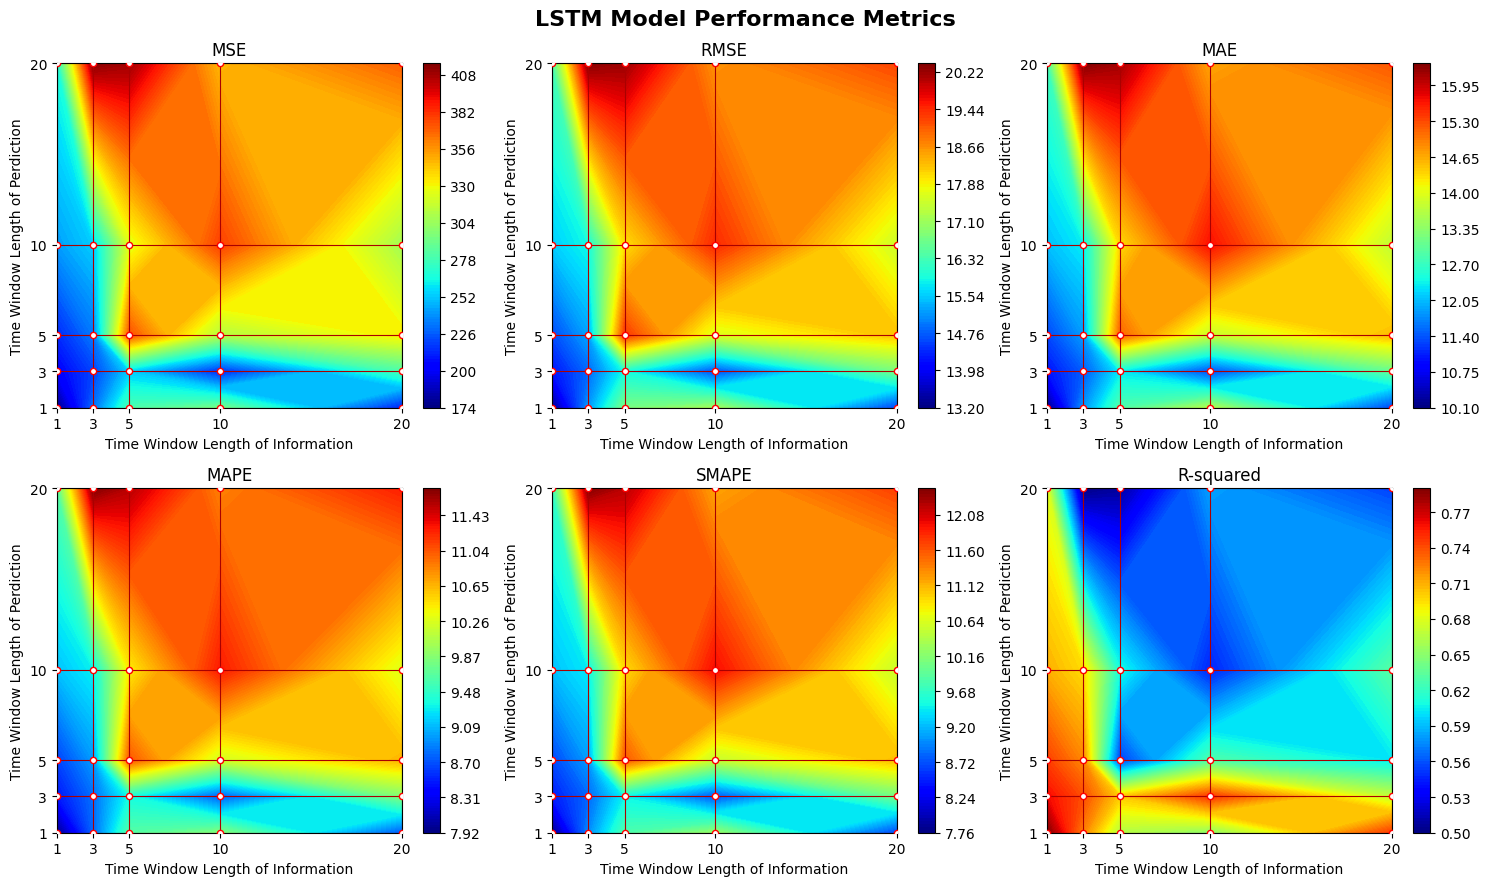

In [91]:
values = np.array([1, 3, 5, 10, 20])

fig, axs = plt.subplots(2, 3, figsize=(15, 9), tight_layout=True)
metrics_list = ["MSE", "RMSE", "MAE", "MAPE", "SMAPE", "R-squared"]
fig.suptitle('LSTM Model Performance Metrics', fontsize=16, fontweight='bold')

for ax, metric_name in zip(axs.flatten(), metrics_list):
    
    Z = np.zeros((len(values), len(values)))
    for i, x in enumerate(values):
        for j, y in enumerate(values):
            key = f'LSTM_{x}_{y}'
            Z[i, j] = metrics[key][metric_name]

    X, Y = np.meshgrid(values, values)

    print(metric_name,Z)
    
    contour = ax.contourf(Y, X, Z, levels=128, cmap='jet')
    fig.colorbar(contour, ax=ax)
    ax.set_title(metric_name)
    ax.set_xlabel('Time Window Length of Information')
    ax.set_ylabel('Time Window Length of Perdiction')
    ax.set_xticks(values)
    ax.set_yticks(values)
    ax.grid(True, linestyle='-', color='#AA0000')
    ax.scatter(X, Y, color='white', s=20, edgecolors='red', zorder=5)
    
plt.savefig('LSTM_Model_Performance_Metrics.pdf')
plt.show()

In [64]:
metrics['LSTM_1_20']['MSE']

266.2215

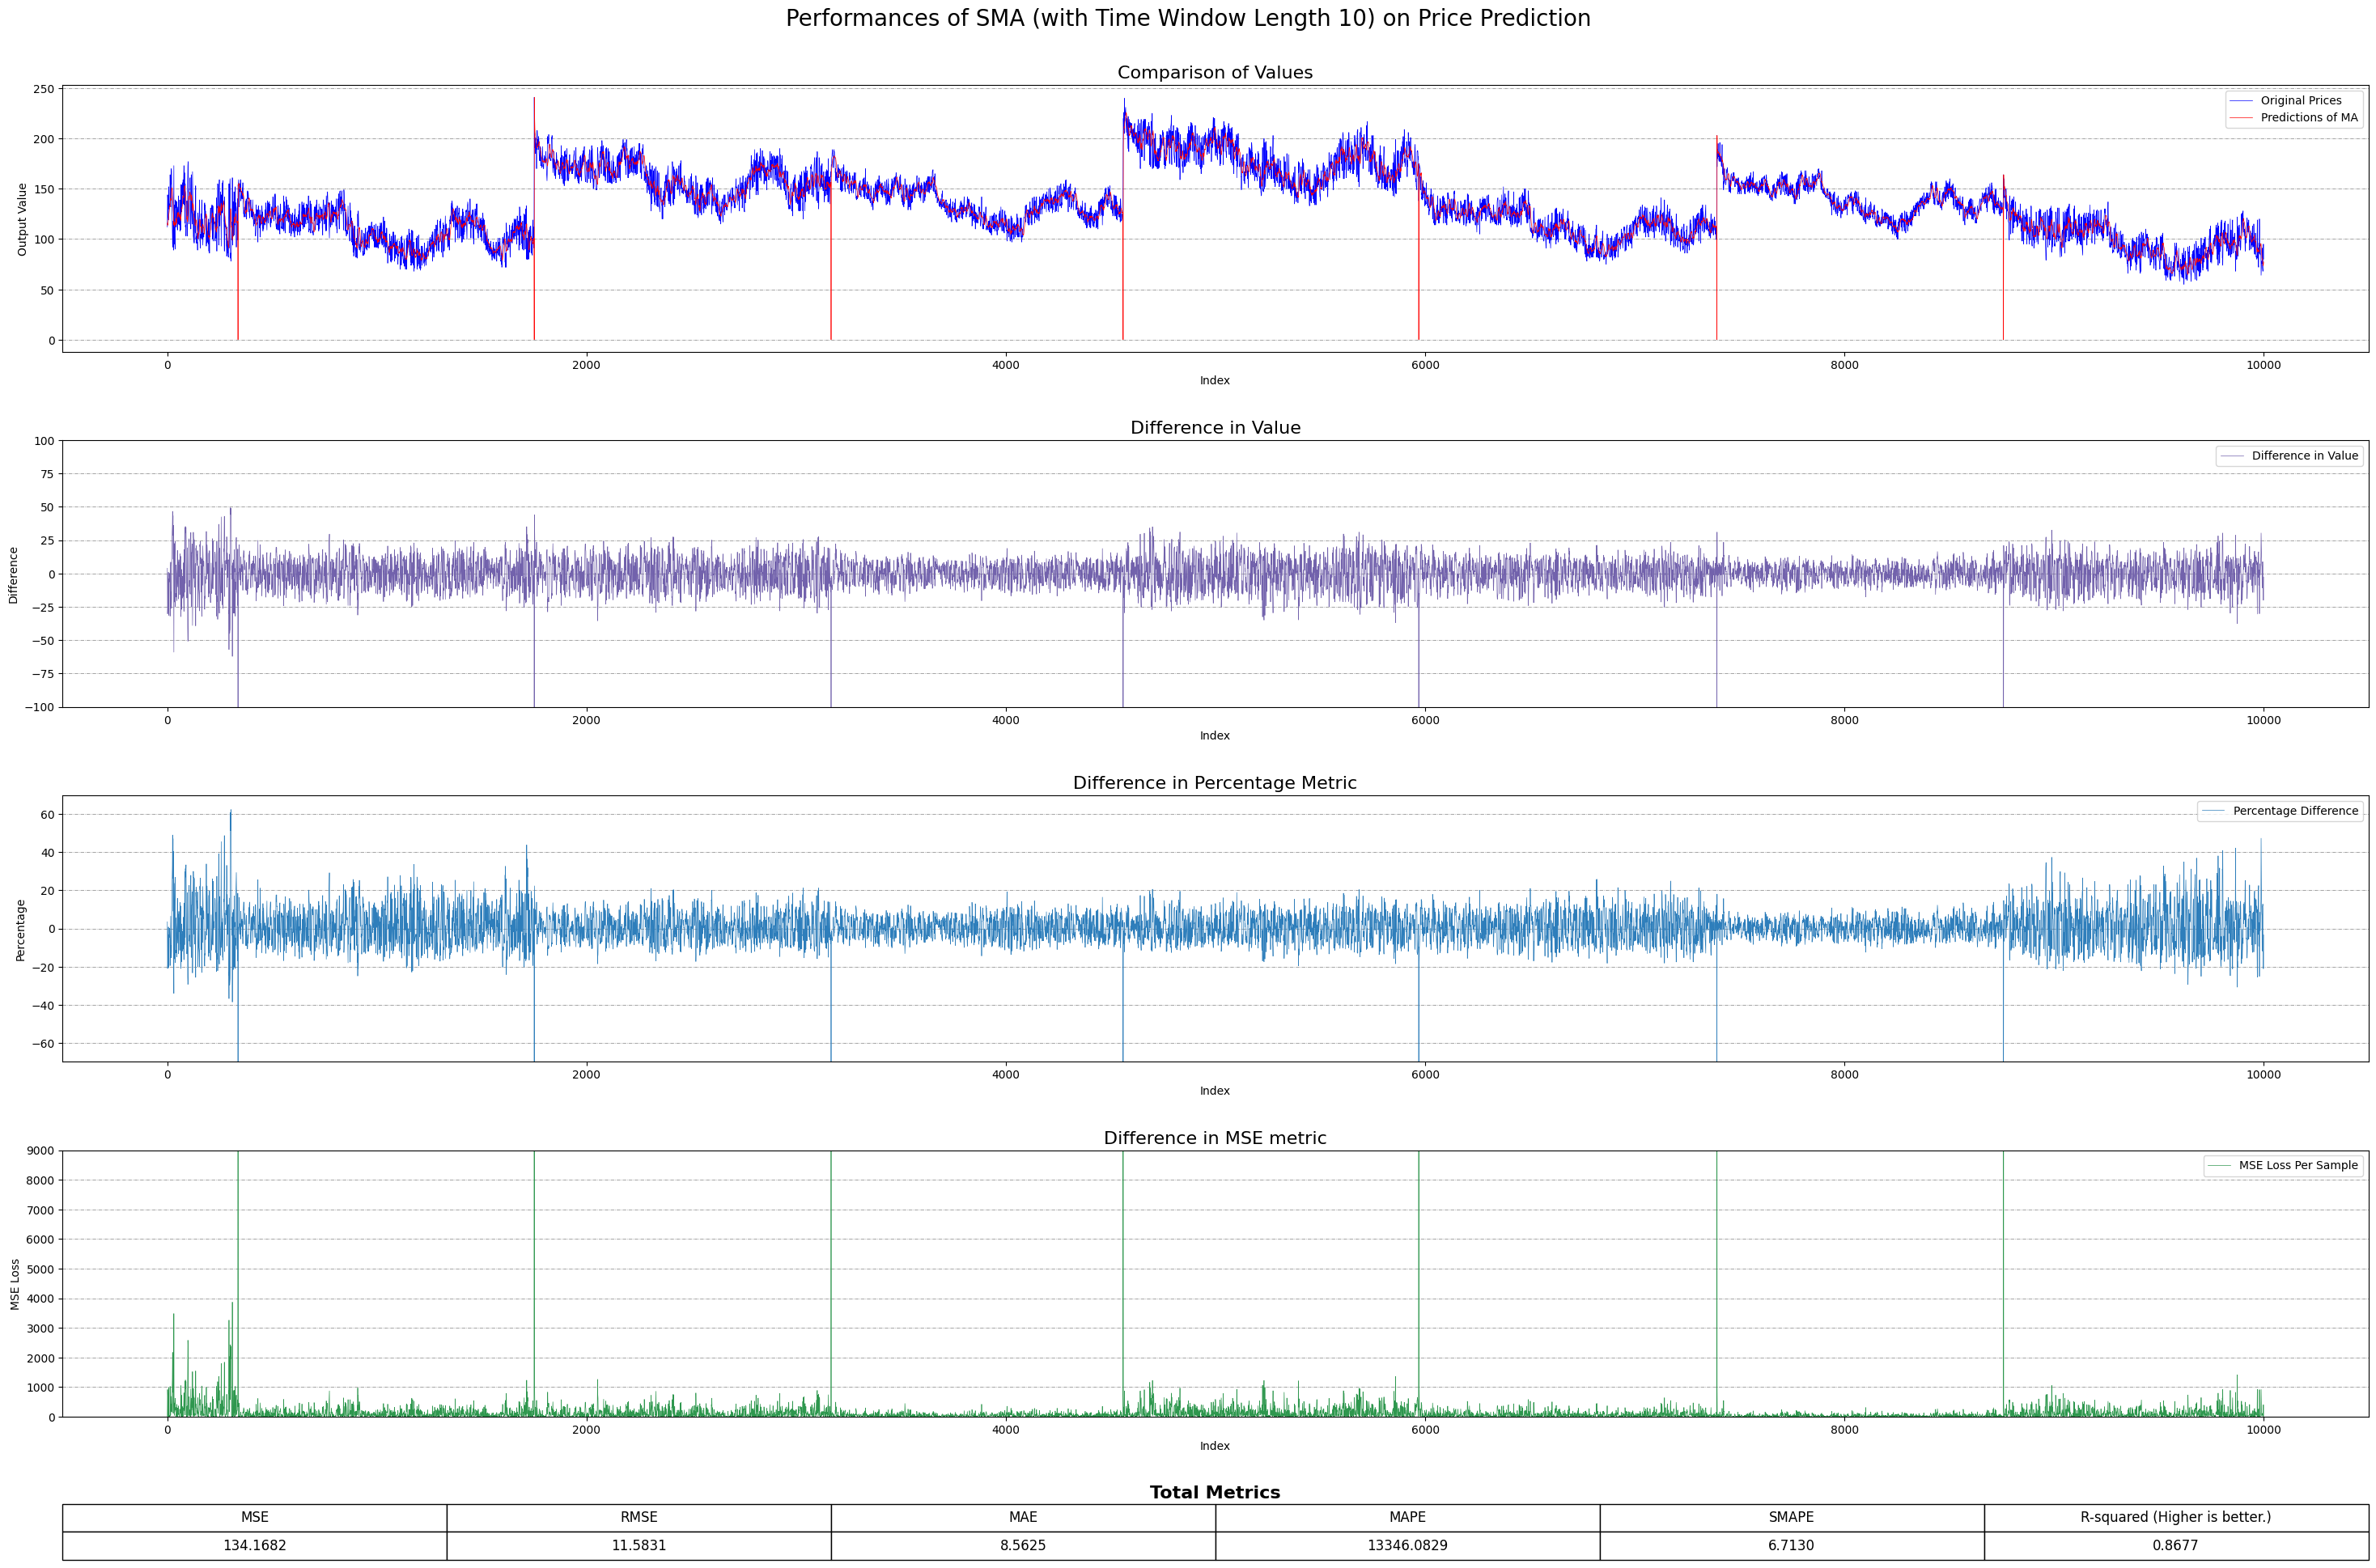

In [76]:
# Moving Averaging Plots

section_len = 10000
section_start = 492500

if (section_start + section_len > len(dataset_test_dn.dataset['outputs'])):
    raise ValueError('Length Overflow: The requested section exceeds the available data size.')

outputs_original = dataset_test_dn.dataset['outputs'][section_start:section_start + section_len].squeeze()

method_MA = 'SMA'
outputs_MA = moving_average(dataset_test_dn, method_MA, seq_len_ma)[section_start:section_start + section_len].squeeze()

diffs_in_val = outputs_MA - outputs_original

diffs_in_percent = np.where(outputs_original != 0, 
                            (outputs_MA - outputs_original) / outputs_original * 100, 
                            0)

criterion_no_reduction = nn.MSELoss(reduction='none')
diffs_in_loss = criterion_no_reduction(torch.tensor(outputs_MA, dtype=torch.float32), 
                                       torch.tensor(outputs_original, dtype=torch.float32)).detach().numpy()


metrics[f'{method_MA}_{seq_len_ma}'] = {
    'MSE': np.mean((outputs_original - outputs_MA) ** 2),
    'RMSE': np.sqrt(np.mean((outputs_original - outputs_MA) ** 2)),
    'MAE': np.mean(np.abs(outputs_original - outputs_MA)),
    'MAPE': np.mean(np.abs((outputs_original - outputs_MA/outputs_original)))*100,
    'SMAPE': 100 * np.mean(2 * np.abs(outputs_MA - outputs_original) / (np.abs(outputs_MA) + np.abs(outputs_original))),
    'R-squared': 1 - (np.sum((outputs_original - outputs_MA) ** 2) / np.sum((outputs_original - np.mean(outputs_original)) ** 2)),
}


fig, axs = plt.subplots(5, 1, figsize=(30, 20), gridspec_kw={'height_ratios': [1, 1, 1, 1, 0.2]})  


axs[0].plot(outputs_original, label='Original Prices', color='blue',linewidth=0.5)
axs[0].plot(outputs_MA, label='Predictions of MA', color='red',linewidth=0.5)
axs[0].set_title('Comparison of Values',fontsize = 16)
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Output Value')
axs[0].legend()

axs[1].plot(diffs_in_val, label='Difference in Value', color='#7262ac',linewidth=0.5)
axs[1].set_title('Difference in Value',fontsize = 16)
axs[1].set_ylim(-100, 100)
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Difference')
axs[1].legend()

axs[2].plot(diffs_in_percent, label='Percentage Difference', color='#2e7ebb',linewidth=0.5)
axs[2].set_title('Difference in Percentage Metric', fontsize = 16)
axs[2].set_ylim(-70, 70)
axs[2].set_xlabel('Index')
axs[2].set_ylabel('Percentage')
axs[2].legend()

axs[3].plot(diffs_in_loss, label='MSE Loss Per Sample', color='#2e974e',linewidth=0.5)
axs[3].set_title('Difference in MSE metric', fontsize = 16)
axs[3].set_ylim(0, 9000)
axs[3].set_xlabel('Index')
axs[3].set_ylabel('MSE Loss')
axs[3].legend()

cell_text = [[f"{v:.4f}" for v in metrics[f'{method_MA}_{seq_len_ma}'].values()]]
columns = list(metrics[f'{method_MA}_{seq_len_ma}'].keys())
columns[-1]+=' (Higher is better.)'

axs[4].set_title('Total Metrics', fontweight='bold', fontsize=16)

axs[4].axis('tight')
axs[4].axis('off')
table = axs[4].table(cellText=cell_text, colLabels=columns, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2)

for ax_i in axs:
    ax_i.grid(True, axis = 'y', linestyle='-.', linewidth=0.5, color='gray')

plt.suptitle(f'Performances of {method_MA} (with Time Window Length {seq_len_ma}) on Price Prediction',fontsize = 20)
fig.tight_layout(pad=3.0)
plt.savefig(f'{method_MA}-T{seq_len_ma} Performances.pdf', format='pdf')
plt.show()

/var/folders/b6/kmqmc4952k7__8jzcqjy4jn00000gn/T/ipykernel_69158/2912212724.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  PPMLP_model.load_state_dict(torch.load(model_

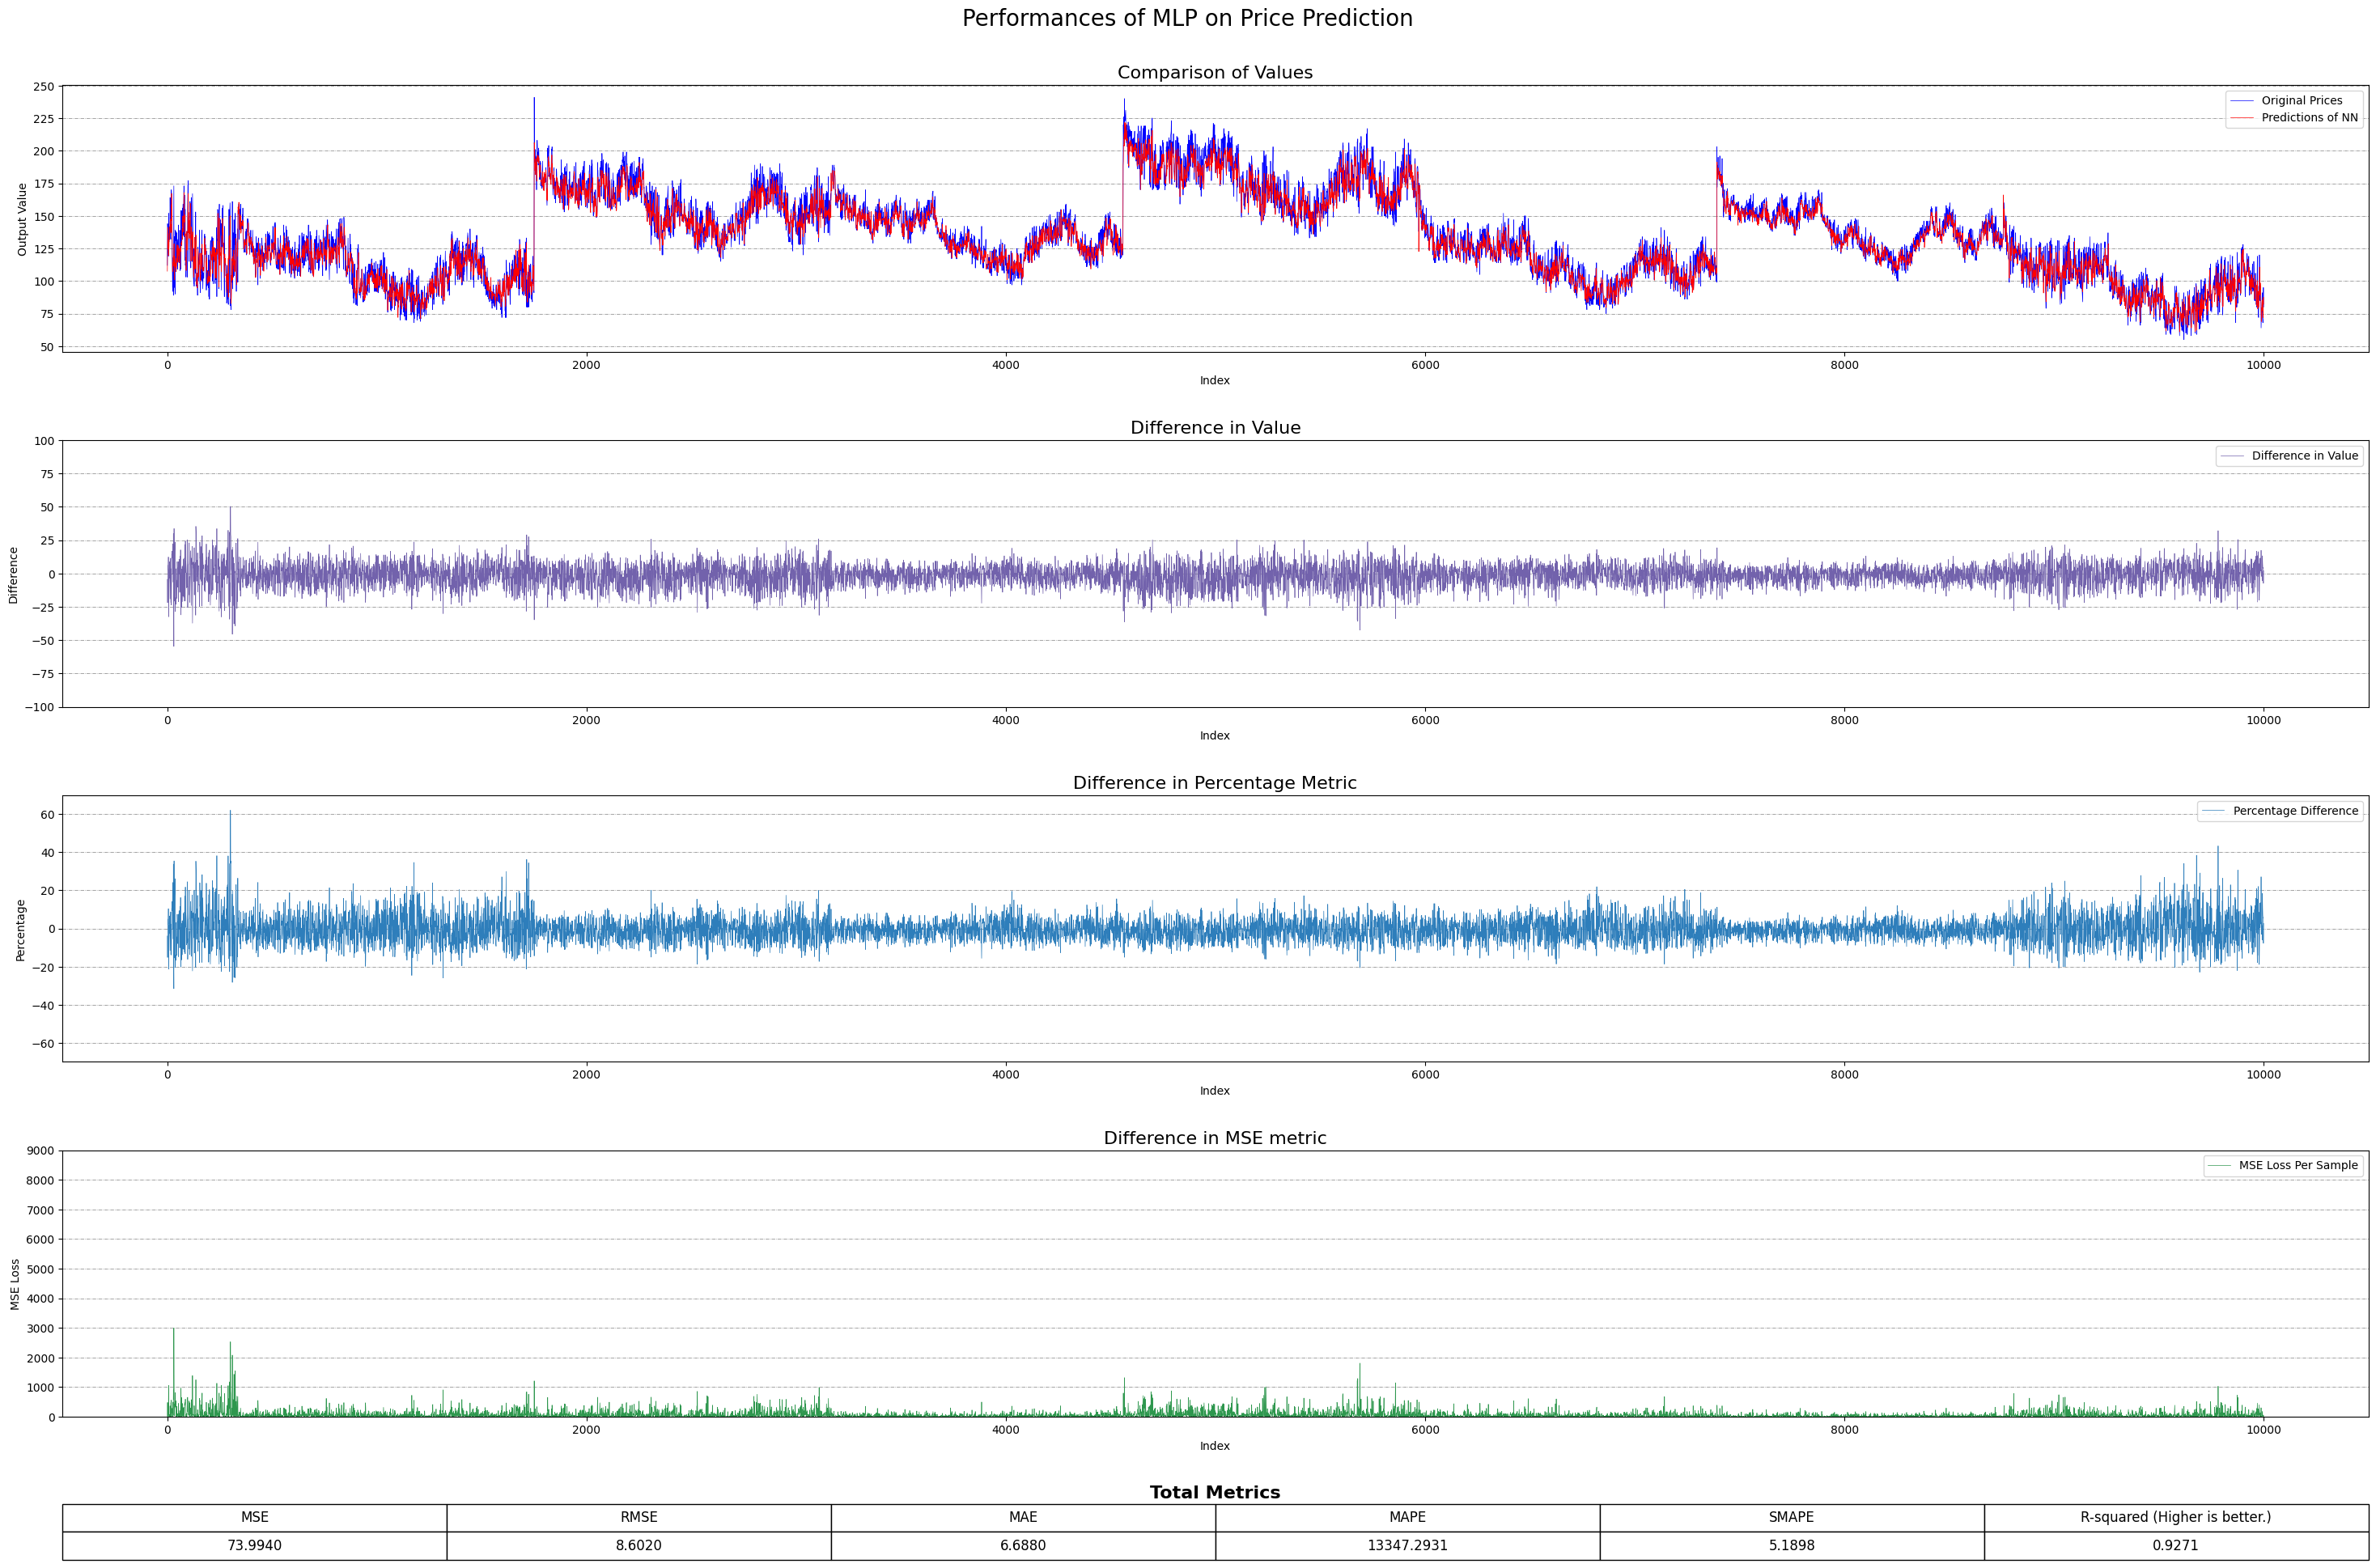

In [73]:
# MLP Plot

model_save_path_MLP = f'PPMLP_model.pt'
optimizer_save_path_MLP = f'PPMLP_optimizer.pt'

PPMLP_model = PP_MLP(init_method = 'uniform').to('cpu')
PPMLP_model.load_state_dict(torch.load(model_save_path_MLP))
PPMLP_model.eval()
# Collection of Data

section_len = 10000
section_start = 492500

dataset_test_MLP = H5Dataset('../data/lob_data/lob_data_test.h5','n')

if (section_start + section_len > len(dataset_test_dn.dataset['outputs'])):
    raise ValueError('Length Overflow: The requested section exceeds the available data size.')

inputs = torch.tensor(dataset_test_MLP.dataset['inputs'][section_start:section_start + section_len], dtype=torch.float32)

outputs_original = dataset_test_dn.dataset['outputs'][section_start:section_start + section_len].squeeze()
outputs_NN = denormalize(dataset_test_dn, PPMLP_model, inputs).detach().numpy().squeeze()

diffs_in_val = outputs_NN - outputs_original

diffs_in_percent = np.where(outputs_original != 0, 
                            (outputs_NN - outputs_original) / outputs_original * 100, 
                            0)

criterion_no_reduction = nn.MSELoss(reduction='none')
diffs_in_loss = criterion_no_reduction(torch.tensor(outputs_NN, dtype=torch.float32), 
                                       torch.tensor(outputs_original, dtype=torch.float32)).detach().numpy()

metrics['MLP'] = {
    'MSE': np.mean((outputs_original - outputs_NN) ** 2),
    'RMSE': np.sqrt(np.mean((outputs_original - outputs_NN) ** 2)),
    'MAE': np.mean(np.abs(outputs_original - outputs_NN)),
    'MAPE': np.mean(np.abs((outputs_original - outputs_NN/outputs_original)))*100,
    'SMAPE': 100 * np.mean(2 * np.abs(outputs_NN - outputs_original) / (np.abs(outputs_NN) + np.abs(outputs_original))),
    'R-squared': 1 - (np.sum((outputs_original - outputs_NN) ** 2) / np.sum((outputs_original - np.mean(outputs_original)) ** 2)),
}

fig, axs = plt.subplots(5, 1, figsize=(30, 20), gridspec_kw={'height_ratios': [1, 1, 1, 1, 0.2]})  


axs[0].plot(outputs_original, label='Original Prices', color='blue',linewidth=0.5)
axs[0].plot(outputs_NN, label='Predictions of NN', color='red',linewidth=0.5)
axs[0].set_title('Comparison of Values',fontsize = 16)
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Output Value')
axs[0].legend()

axs[1].plot(diffs_in_val, label='Difference in Value', color='#7262ac',linewidth=0.5)
axs[1].set_title('Difference in Value',fontsize = 16)
axs[1].set_ylim(-100, 100)
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Difference')
axs[1].legend()

axs[2].plot(diffs_in_percent, label='Percentage Difference', color='#2e7ebb',linewidth=0.5)
axs[2].set_title('Difference in Percentage Metric', fontsize = 16)
axs[2].set_ylim(-70, 70)
axs[2].set_xlabel('Index')
axs[2].set_ylabel('Percentage')
axs[2].legend()

axs[3].plot(diffs_in_loss, label='MSE Loss Per Sample', color='#2e974e',linewidth=0.5)
axs[3].set_title('Difference in MSE metric', fontsize = 16)
axs[3].set_ylim(0, 9000)
axs[3].set_xlabel('Index')
axs[3].set_ylabel('MSE Loss')
axs[3].legend()

cell_text = [[f"{v:.4f}" for v in metrics['MLP'].values()]]
columns = list(metrics['MLP'].keys())
columns[-1]+=' (Higher is better.)'
axs[4].set_title('Total Metrics', fontweight='bold', fontsize=16)

axs[4].axis('tight')
axs[4].axis('off')
table = axs[4].table(cellText=cell_text, colLabels=columns, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2)

for ax_i in axs:
    ax_i.grid(True, axis = 'y', linestyle='-.', linewidth=0.5, color='gray')

plt.suptitle(f'Performances of MLP on Price Prediction',fontsize = 20)
fig.tight_layout(pad=3.0)
plt.savefig(f'MLP Performances.pdf', format='pdf')
plt.show()

In [91]:
trial = np.array([0,1,2,3,4,5,6])
diffs = np.diff(trial)
end_of_cycle_indices = np.where(diffs < 0)[0]

In [99]:
import numpy as np

def sliding_window(arr, window_size):
    # 计算滑动窗口的数量
    num_windows = len(arr) - window_size + 1
    # 使用 NumPy 的 stride_tricks 来创建滑动窗口
    return np.lib.stride_tricks.sliding_window_view(arr, window_shape=window_size)

# 示例数组
array = np.linspace(0,20,21)
# 指定窗口大小
n = 4

# 获取滑动窗口结果
result = sliding_window(array[1:], n)
print(result)

[[ 1.  2.  3.  4.]
 [ 2.  3.  4.  5.]
 [ 3.  4.  5.  6.]
 [ 4.  5.  6.  7.]
 [ 5.  6.  7.  8.]
 [ 6.  7.  8.  9.]
 [ 7.  8.  9. 10.]
 [ 8.  9. 10. 11.]
 [ 9. 10. 11. 12.]
 [10. 11. 12. 13.]
 [11. 12. 13. 14.]
 [12. 13. 14. 15.]
 [13. 14. 15. 16.]
 [14. 15. 16. 17.]
 [15. 16. 17. 18.]
 [16. 17. 18. 19.]
 [17. 18. 19. 20.]]


In [98]:
array[:-n]

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16.])